## <a id='table of contents'>Содержание</a>  
<a href='#part1'>1. ПОСТАНОВКА ЗАДАЧИ</a>     
<a href='#part2'>2. ЗАГРУЗКА И ОПИСАНИЕ ДАННЫХ</a>    
<a href='#part3'>3. ПОДГОТОВКА ДАННЫХ</a>    
<a href='#part4'>4. АНАЛИЗ ДАННЫХ</a>  
<a href='#part5'>5. ПОДГОТОВКА К ОБУЧЕНИЮ МОДЕЛЕЙ </a>   
<a href='#part6'>6. ОБУЧЕНИЕ МОДЕЛЕЙ</a>   
<a href='#part7'>6.1. Обучение моделей для предсказания rougher.output.recovery</a>  
<a href='#part8'>6.2. Обучение моделей для предсказания final.output.recovery</a>  
<a href='#part9'>7.Расчет итогового sMAPE </a>     

# <a id='part1'>1. ПОСТАНОВКА ЗАДАЧИ</a>
<a href='#table of contents'>к оглавлению</a>

***Цель:*** Построить модель машинного обучения, которая будет предсказывать коэффициент восстановления золота из золотосодержащей руды.   
***Целевая метрика:*** sMAPE 

# <a id='part2'> 2. ЗАГРУЗКА И ОПИСАНИЕ ДАННЫХ</a>
<a href='#table of contents'>к оглавлению</a>

***Rougher feed*** — исходное сырье  
***Rougher additions (или reagent additions)*** — флотационные реагенты: Xanthate, Sulphate, Depressant  
***Xanthate*** — ксантогенат (промотер, или активатор флотации)  
***Sulphate*** — сульфат (на данном производстве сульфид натрия)  
***Depressant*** — депрессант (силикат натрия)  
***Rougher process (англ. «грубый процесс»)*** — флотация  
***Rougher tails*** — отвальные хвосты  
***Float banks*** — флотационная установка  
***Cleaner process*** — очистка  
***Rougher Au*** — черновой концентрат золота  
***Final Au*** — финальный концентрат золота  

### Параметры этапов###

***air amount*** — объём воздуха  
***fluid levels*** — уровень жидкости  
***feed size*** — размер гранул сырья  
***feed rate*** — скорость подачи  

### Наименование признаков###

[этап].[тип_параметра].[название_параметра]  
***Пример:*** rougher.input.feed_ag  
***Возможные значения для блока [этап]:***  
***rougher*** — флотация  
***primary_cleaner*** — первичная очистка  
***secondary_cleaner*** — вторичная очистка  
***final*** — финальные характеристики  
***Возможные значения для блока [тип_параметра]:***  
***input*** — параметры сырья  
***output*** — параметры продукта  
***state*** — параметры, характеризующие текущее состояние этапа  
***calculation*** — расчётные характеристики  

### Целевые признаки ###

***rougher.output.recovery*** - эффективность обогащения чернового концентрата  
***final.output.recovery*** - эффективность обогащения финального концентрата

In [1]:
import pandas 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from IPython.display import Image
from scipy import stats as st
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
try:
    df_train=pd.read_csv('gold_recovery_train.csv', sep=',') 
    df_test=pd.read_csv('gold_recovery_test.csv', sep=',') 
    df_full=pd.read_csv('gold_recovery_full.csv', sep=',') 
except: 
    df_train=pd.read_csv('/datasets/gold_recovery_train.csv', sep=',') 
    df_test=pd.read_csv('/datasets/gold_recovery_test.csv', sep=',') 
    df_full=pd.read_csv('/datasets/gold_recovery_full.csv', sep=',')  
pd.options.display.float_format = '{:.2f}'.format

In [2]:
df_sum=[df_train, df_test, df_full]

In [3]:
for i in df_sum:
    display(i.head())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,...,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,...,13.99,-505.50,11.95,-501.33,10.04,-500.17,7.98,-500.58,14.00,-599.79
2,2016-01-15 02:00:00,6.06,10.21,5.38,42.66,68.12,10.51,0.95,16.21,2.26,...,14.02,-502.52,11.91,-501.13,10.07,-500.13,8.01,-500.52,14.03,-601.43
3,2016-01-15 03:00:00,6.05,9.98,4.86,42.69,68.35,10.42,0.88,16.53,2.15,...,14.04,-500.86,12.00,-501.19,9.97,-499.20,7.98,-500.26,14.01,-600.00
4,2016-01-15 04:00:00,6.15,10.14,4.94,42.77,66.93,10.36,0.79,16.53,2.06,...,14.03,-499.84,11.95,-501.05,9.93,-501.69,7.89,-500.36,14.00,-601.50


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.80,14.99,8.08,1.01,1398.98,-500.23,1399.14,-499.92,1400.10,...,12.02,-497.80,8.02,-501.29,7.95,-432.32,4.87,-500.04,26.71,-499.71
1,2016-09-01 01:59:59,215.39,14.99,8.08,0.99,1398.78,-500.06,1398.06,-499.78,1396.15,...,12.06,-498.70,8.13,-499.63,7.96,-525.84,4.88,-500.16,25.02,-499.82
2,2016-09-01 02:59:59,215.26,12.88,7.79,1.00,1398.49,-500.87,1398.86,-499.76,1398.08,...,11.96,-498.77,8.10,-500.83,8.07,-500.80,4.91,-499.83,24.99,-500.62
3,2016-09-01 03:59:59,215.34,12.01,7.64,0.86,1399.62,-498.86,1397.44,-499.21,1400.13,...,12.03,-498.35,8.07,-499.47,7.90,-500.87,4.93,-499.96,24.95,-498.71
4,2016-09-01 04:59:59,199.10,10.68,7.53,0.81,1401.27,-500.81,1398.13,-499.50,1402.17,...,12.03,-500.79,8.05,-500.40,8.11,-509.53,4.96,-500.36,25.00,-500.86


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,...,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,...,13.99,-505.50,11.95,-501.33,10.04,-500.17,7.98,-500.58,14.00,-599.79
2,2016-01-15 02:00:00,6.06,10.21,5.38,42.66,68.12,10.51,0.95,16.21,2.26,...,14.02,-502.52,11.91,-501.13,10.07,-500.13,8.01,-500.52,14.03,-601.43
3,2016-01-15 03:00:00,6.05,9.98,4.86,42.69,68.35,10.42,0.88,16.53,2.15,...,14.04,-500.86,12.00,-501.19,9.97,-499.20,7.98,-500.26,14.01,-600.00
4,2016-01-15 04:00:00,6.15,10.14,4.94,42.77,66.93,10.36,0.79,16.53,2.06,...,14.03,-499.84,11.95,-501.05,9.93,-501.69,7.89,-500.36,14.00,-601.50


In [4]:
for i in df_sum:
    display(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


None

***Систематизируем столбцы по переделам для тренировочного датасета:***

***date*** - время начала технологического этапа 
Всего 3 этапа, на каждом имеется содержание элементов (ag, pb, au) в исходном сырье и содержание элементов (ag, pb, au) в продукте получаемом после этапа, а также параметры процесса  

***Флотация*** 
 - Содержание в исходной руде:
 rougher.input.feed_ag, rougher.input.feed_pb, rougher.input.feed_au, rougher.input.feed_sol (содержание солей видимо)
 - Параметры процесса - rougher.input.feed_rate (скорость подачи сырья),  
 rougher.input.feed_size - степень измельчения  сырья,   
 rougher.input.floatbank10_sulfate - расход сульфида натрия (почему тогда сульфат???! это сульфид! на установке 10),        
 rougher.input.floatbank10_xanthate - расход ксантогената на установке 10),  
 rougher.input.floatbank11_sulfate - расход ксантогената на установке 11),   
 rougher.input.floatbank11_xanthate - расход ксантогената на установке 11),   
 rougher.state.floatbank10_(a-f)_air - расход воздуха в процессе флотации (a-f - видимо обозначает циклы) на установке 10,  
 rougher.state.floatbank10_(a-f)_level - расход жидкости в процессе флотации (a-f - видимо обозначает циклы) на установке 10
 - Содержание в черновом концентрате и хвостах флотации:
rougher.output.concentrate_ag, rougher.output.concentrate_pb, rougher.output.concentrate_au, rougher.output.concentrate_sol, rougher.output.tail_ag, rougher.output.tail_pb, rougher.output.tail_au, rougher.output.tail_sol
 - Рассчитанные характеристики процесса - rougher.calculation.sulfate_to_au_concentrate - относительный расход сульфида натрия по отношению к золоту в концентрате,  
rougher.calculation.floatbank(10-11)_sulfate_to_au_feed - относительный расход сульфида натрия по отношению к золоту в исходной руде на установках 10 и 11,  
 rougher.output.recovery - эффективность обогащения на этапе флотации,  
 rougher.calculation.au_pb_ratio - отношения содержания золота к свинцу в концентрате
 
***Первый этап очистки*** 
- Параметры процесса (расход реагентов) и параметры работы флотационных машин:  
primary_cleaner.input.sulfate - расход сульфида натрия,  
primary_cleaner.input.depressant - расход депресанта,  
primary_cleaner.input.feed_size - размер частиц,  
primary_cleaner.input.xanthate - расход ксантогената,  
primary_cleaner.state.floatbank8_(a-d)_air - расход воздуха на флотомашине 8,    
primary_cleaner.state.floatbank8_(a-d)_level - расход жидкости на флотомашине 8
- Содержание в концентрате и хвостах флотации после первой очистки:  
primary_cleaner.output.concentrate_ag, primary_cleaner.output.concentrate_pb, primary_cleaner.output.concentrate_sol,
primary_cleaner.output.concentrate_au, primary_cleaner.output.tail_ag, primary_cleaner.output.tail_pb, 
primary_cleaner.output.tail_sol, primary_cleaner.output.tail_au  

***Второй этап очистки*** 
- Содержание в хвостах флотации:  
secondary_cleaner.output.tail_ag, secondary_cleaner.output.tail_pb, secondary_cleaner.output.tail_sol  
- Параметры процесса:  
secondary_cleaner.state.floatbank(2-6)_(a-с)_air - расход воздуха на флотомашинах 2-6   
secondary_cleaner.state.floatbank(2-6)_(a-с)_level - расход жидкости на флотомашинах 2-6  

***Финальный концентрат*** 
- Содержание в итоговых концентрате и хвостах:  
final.output.concentrate_ag, final.output.concentrate_pb, final.output.concentrate_sol, final.output.concentrate_au, 
final.output.tail_ag, final.output.tail_pb, final.output.tail_sol, final.output.tail_au

- Расcчитанные параметры:    
final.output.recovery - извлечение в конечный концентрат 

# <a id='part3'> 3. ПОДГОТОВКА ДАННЫХ</a>
<a href='#table of contents'>к оглавлению</a>

***Проверим правильность расчета эффективности обогащения***

Эффективность обогащения рассчитвается по формуле

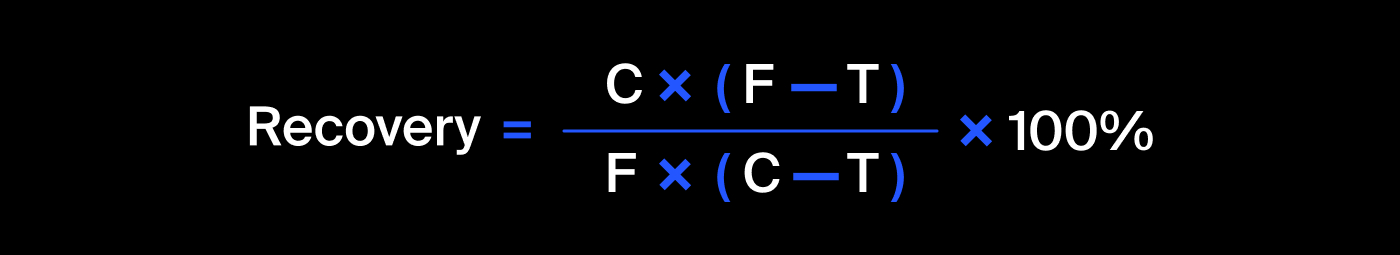

In [5]:
display(Image('https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg'))

где 
- C - доля золота в концентрате после флотации/очистки;
- F - доля золота в сырье/концентрате до флотации/очистки;
- T - доля золота в отвальных хвостах после флотации/очистки.

Напишем функцию для расчета степени извлечения

In [6]:
def recovery (row):
    C=row['rougher.output.concentrate_au']
    F=row['rougher.input.feed_au']
    T=row['rougher.output.tail_au']
    REC=(C*(F-T))/(F*(C-T))*100
    return REC

In [7]:
df_train_recovery=df_train[['rougher.output.concentrate_au', 'rougher.input.feed_au', \
                            'rougher.output.tail_au', 'rougher.output.recovery']]
try:
    df_train_recovery['recovery_verification']=df_train_recovery.apply(recovery, axis=1)
except ZeroDivisionError:
    print("Error")

display(df_train_recovery)


<ipython-input-6-6103f88769fe>:5: RuntimeWarning: divide by zero encountered in double_scalars
  REC=(C*(F-T))/(F*(C-T))*100
<ipython-input-6-6103f88769fe>:5: RuntimeWarning: invalid value encountered in double_scalars
  REC=(C*(F-T))/(F*(C-T))*100
<ipython-input-7-3cf465cec9bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_recovery['recovery_verification']=df_train_recovery.apply(recovery, axis=1)


,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery,recovery_verification
0,19.79,6.49,1.17,87.11,87.11
1,20.05,6.48,1.18,86.84,86.84
2,19.74,6.36,1.16,86.84,86.84
3,19.32,6.12,1.08,87.23,87.23
4,19.22,5.66,1.01,86.69,86.69
...,...,...,...,...,...
16855,18.60,5.34,0.75,89.57,89.57
16856,18.44,4.84,0.77,87.72,87.72
16857,15.11,4.53,0.69,88.89,88.89
16858,17.83,4.36,0.57,89.86,89.86


Рассчитаем MAE

In [8]:
#посчитаем количество пропусков

display(df_train_recovery[['rougher.output.concentrate_au', 'rougher.input.feed_au', \
                            'rougher.output.tail_au', 'rougher.output.recovery', 'recovery_verification']].isnull().sum())

#удалим пропуски

df_train_recovery=df_train_recovery[['rougher.output.concentrate_au', 'rougher.input.feed_au', \
                            'rougher.output.tail_au', 'rougher.output.recovery', 'recovery_verification']].dropna()
df_train_recovery.info()

rougher.output.concentrate_au      82
rougher.input.feed_au              83
rougher.output.tail_au           2249
rougher.output.recovery          2573
recovery_verification            2283
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14287 entries, 0 to 16859
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   rougher.output.concentrate_au  14287 non-null  float64
 1   rougher.input.feed_au          14287 non-null  float64
 2   rougher.output.tail_au         14287 non-null  float64
 3   rougher.output.recovery        14287 non-null  float64
 4   recovery_verification          14287 non-null  float64
dtypes: float64(5)
memory usage: 669.7 KB


In [9]:
mae = mean_absolute_error(df_train_recovery['rougher.output.recovery'], df_train_recovery['recovery_verification'])
print('Абсолютное отклонение для расчета mae')

Абсолютное отклонение для расчета mae


***Обработаем нулевые  значения***

Нулевые значения в исходной руде могут быть связаны с точностью измерения концентрации элемента. Например, прибор определяет концентрацию элемента с точность до 3 знаков, а в исходной пробе содержание элемента в 4 знаке. После обогащения, концентрация элемента увеличивается и прибор уже фиксирует содержание элемента, хотя в исходной пробе оно было равно 0. Также нулевые значения могут быть связаны с ошибками в определениях, поэтому пока оставим нулевые значения без изменений и посмотрим, что делать с ними на следующих этапах

***Обработаем пропуски***

Исходя из того, что близкие по времени значения схожи можно заменить пропуски предыдущим по времени значением

In [10]:
df_train=df_train.fillna(method='ffill')
df_test=df_test.fillna(method='ffill')
df_full=df_full.fillna(method='ffill')

### ВЫВОД 1###
- Абсолютное отклонение очень маленькое, а это значит что показатель ***recovery*** рассчитан верно
- Данные которые отсутствуют в тестовой выборке являются промежуточными данными, которые мы получаем в результате обработки руды. Так как эти данные появляются в ходе процесса их нельзя использовать для предсказания
- Пропуски в данных можно заменить на ближайшее по времени значение

# <a id='part4'> 4. АНАЛИЗ ДАННЫХ</a>
<a href='#table of contents'>к оглавлению</a>

***Проанализируем изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки***

Создадим функцию для построения графиков

In [11]:
def concentrate_plot(data1,data2,data3, data4):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    data1.plot(kind='hist', bins=100, figsize=(16,8), alpha=.5, density=True, title=name,
                    label=('Содержание элемента в исходной руде'), legend=True, grid=True)

    data2.plot(kind='hist', bins=100, figsize=(16,8), alpha=.5,  density=True,
                     label=('Содержание элемента после флотации'), legend=True, grid=True)

    data3.plot(kind='hist', bins=100, figsize=(16,8), alpha=.5, density=True,
                     label=('Содержание элемента после первой очистки'), legend=True, grid=True)

    data4.plot(kind='hist', bins=100, figsize=(16,8), alpha=.5, density=True,
                     label=('Содержание элемента после второй очистки'), legend=True, grid=True)
    plt.xlabel('Концентрация элемента', fontsize = 15)
    plt.ylabel('Частота', fontsize = 15)
    plt.show()

Выведем изменение содержания золота в концентрате по технологическим переделам

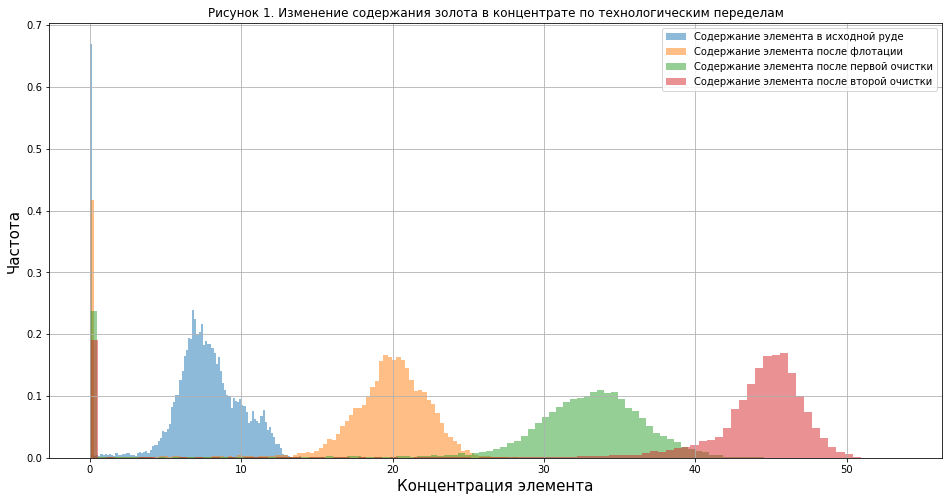

In [12]:
name='Рисунок 1. Изменение содержания золота в концентрате по технологическим переделам'
concentrate_plot (df_train['rougher.input.feed_au'], df_train['rougher.output.concentrate_au'],
                 df_train['primary_cleaner.output.concentrate_au'], df_train['final.output.concentrate_au'])

Выведем изменение содержания серебра в концентрате по технологическим переделам

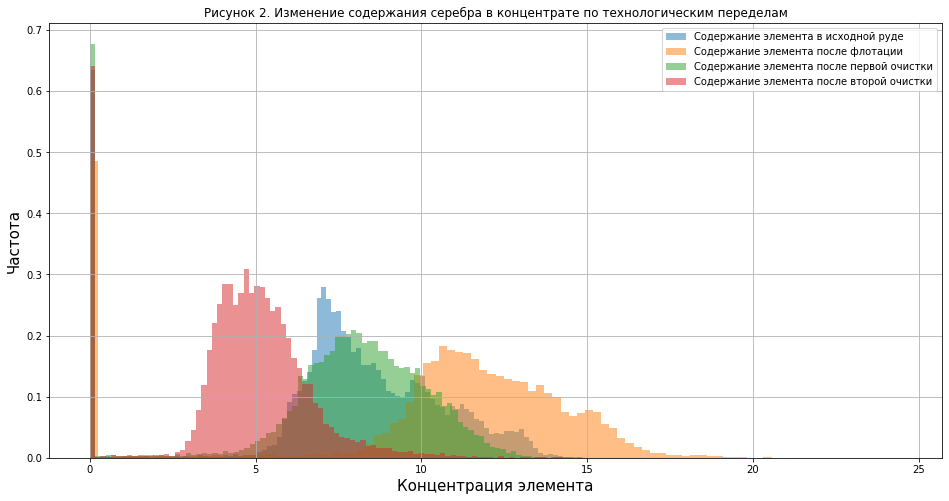

In [13]:
name='Рисунок 2. Изменение содержания серебра в концентрате по технологическим переделам'
concentrate_plot (df_train['rougher.input.feed_ag'], df_train['rougher.output.concentrate_ag'],
                 df_train['primary_cleaner.output.concentrate_ag'], df_train['final.output.concentrate_ag'])

Выведем изменение содержания свинца в концентрате по технологическим переделам

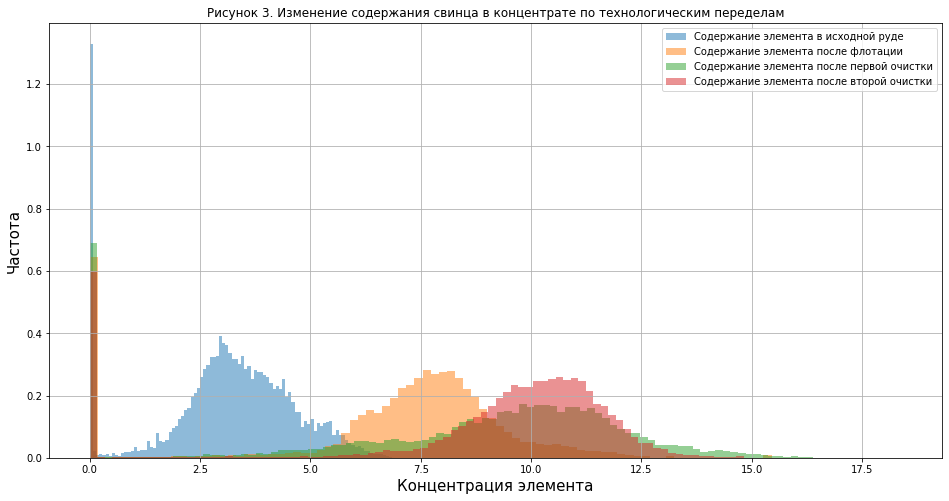

In [14]:
name='Рисунок 3. Изменение содержания свинца в концентрате по технологическим переделам'
concentrate_plot (df_train['rougher.input.feed_pb'], df_train['rougher.output.concentrate_pb'],
                 df_train['primary_cleaner.output.concentrate_pb'], df_train['final.output.concentrate_pb'])

***Сравним распределение размеров гранул сырья на обучающей и тестовой выборках***

Выведем распределение размеров гранул сырья по переделам по обучающей и тренировочной выборкам

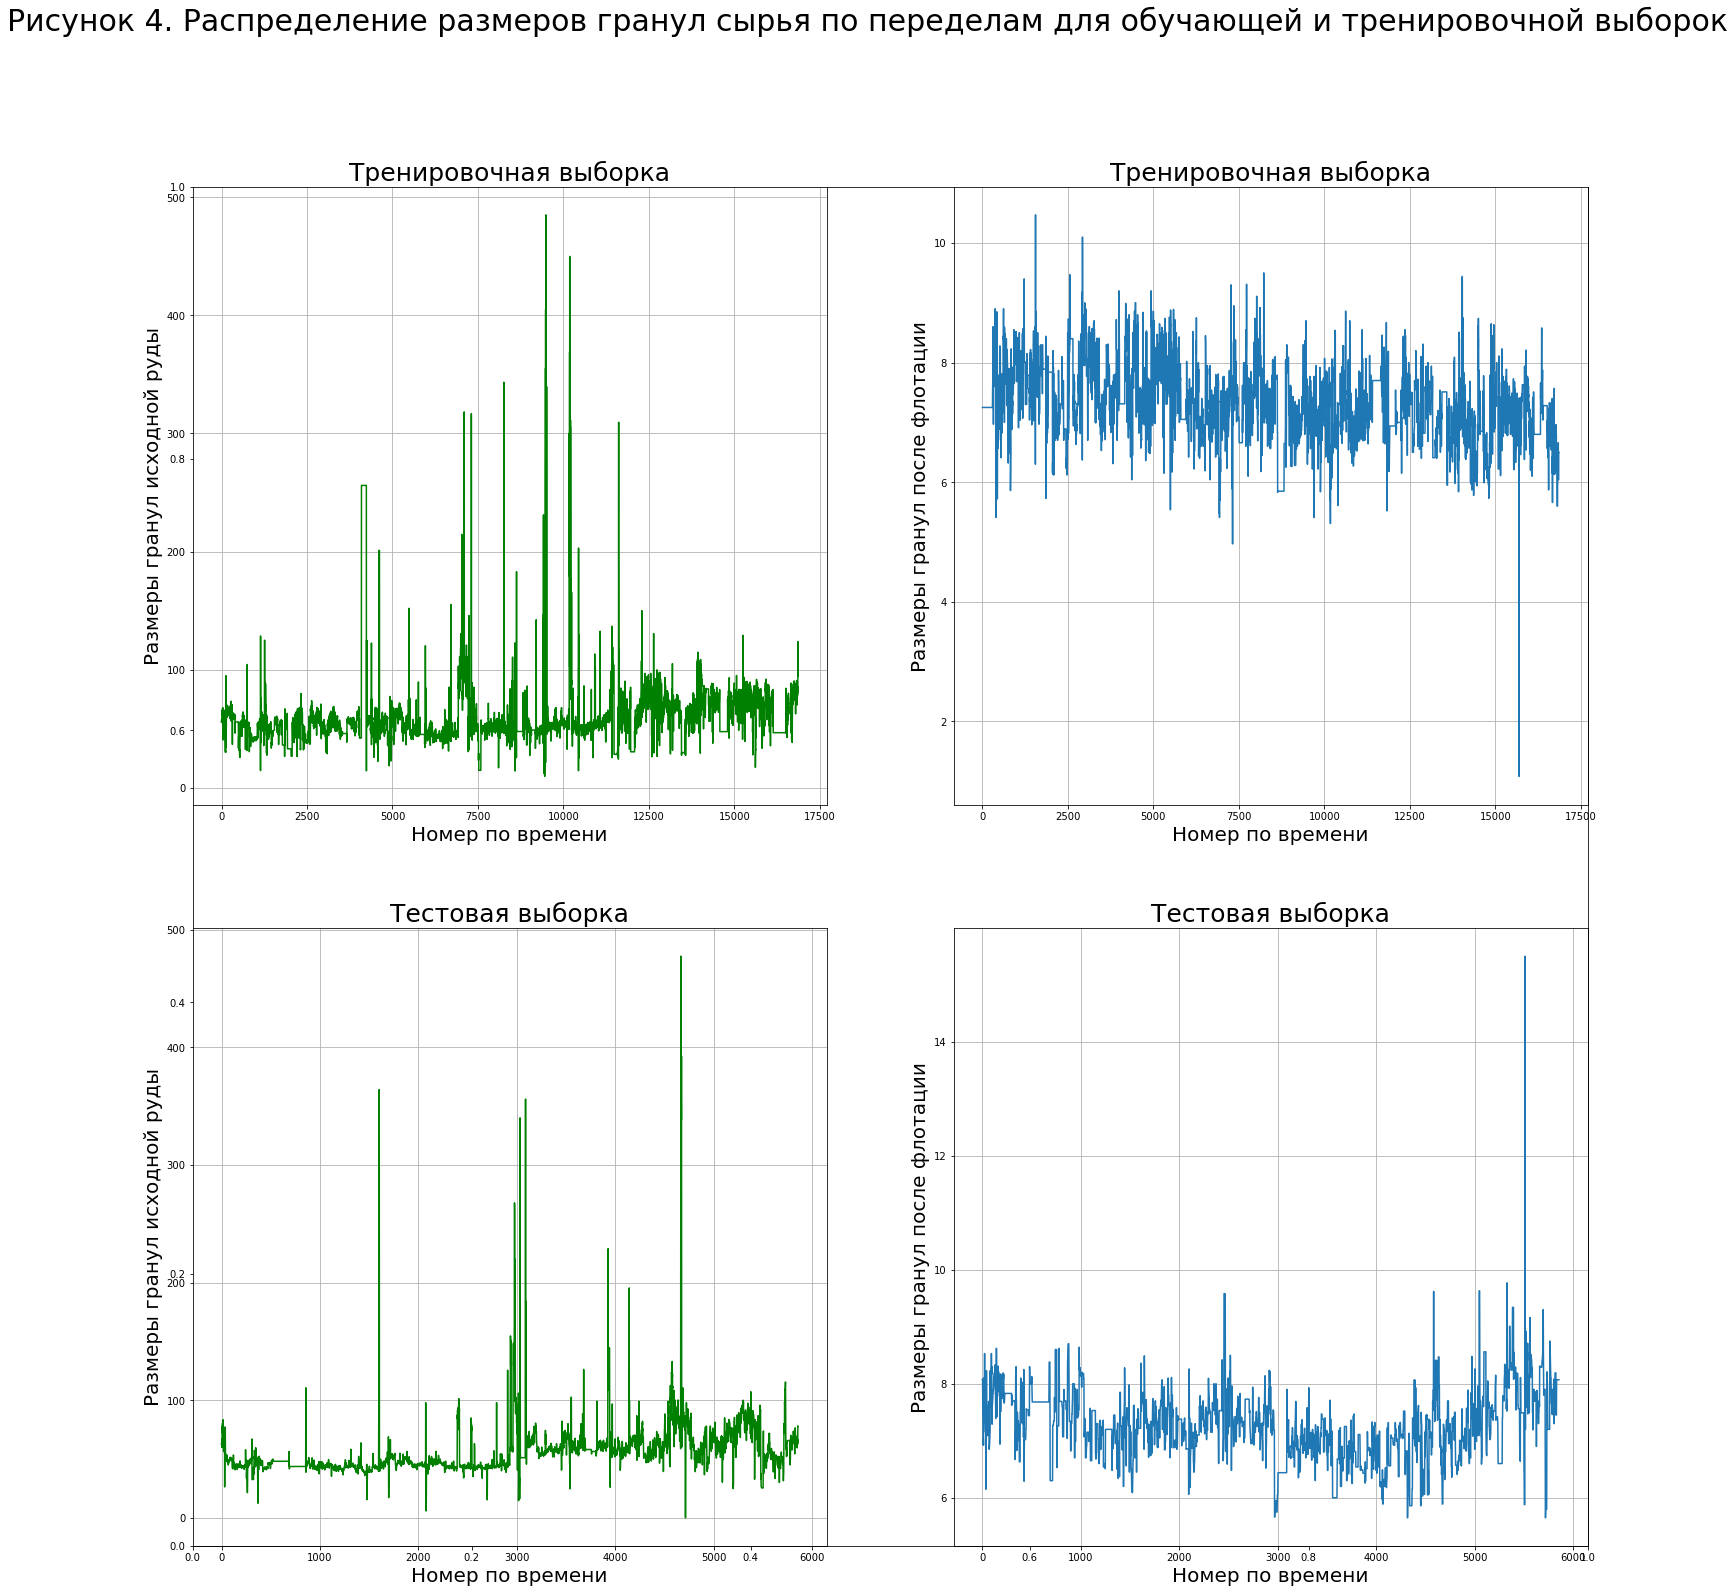

In [15]:
text_size_axis=20
text_size_title=25
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
fig.suptitle('Рисунок 4. Распределение размеров гранул сырья по переделам для обучающей и тренировочной выборок', fontsize = 30) 

ax_1 = fig.add_subplot(2, 2, 1)
df_train['rougher.input.feed_size'].plot(grid=True, color='green')

plt.xlabel('Номер по времени', fontsize = text_size_axis)
plt.ylabel('Размеры гранул исходной руды', fontsize = text_size_axis)

ax_1.set_title('Тренировочная выборка',
                  fontsize = text_size_title)

ax_2 = fig.add_subplot(2, 2, 2)

plt.xlabel('Номер по времени', fontsize = text_size_axis)
plt.ylabel('Размеры гранул после флотации', fontsize = text_size_axis)

df_train['primary_cleaner.input.feed_size'].plot(grid=True)

ax_2.set_title('Тренировочная выборка',
                  fontsize = text_size_title)

ax_3 = fig.add_subplot(2, 2, 3)
df_test['rougher.input.feed_size'].plot(grid=True, color='green')

plt.xlabel('Номер по времени', fontsize = text_size_axis)
plt.ylabel('Размеры гранул исходной руды', fontsize = text_size_axis)

ax_3.set_title('Тестовая выборка',
                  fontsize = text_size_title)

ax_4 = fig.add_subplot(2, 2, 4)

plt.xlabel('Номер по времени', fontsize = text_size_axis)
plt.ylabel('Размеры гранул после флотации', fontsize = text_size_axis)

df_test['primary_cleaner.input.feed_size'].plot(grid=True)

ax_4.set_title('Тестовая выборка',
                  fontsize = text_size_title)

plt.show()

***Проверим гипотезу и равенстве средних распределений***

In [16]:
rougher_input_feed_size_train=np.var(df_train['rougher.input.feed_size'])
primary_cleaner_input_feed_size_train=np.var(df_train['primary_cleaner.input.feed_size'])
rougher_input_feed_size_test=np.var(df_test['rougher.input.feed_size'])
primary_cleaner_input_feed_size_test=np.var(df_test['primary_cleaner.input.feed_size'])
                               
print("Дисперсия размера сырья исходной руды на тренировоччной выборке", rougher_input_feed_size_train)
print("Дисперсия размера сырья после флотации на тренировоччной выборке", primary_cleaner_input_feed_size_train)
print("Дисперсия размера сырья исходной руды на тестовой выборке", rougher_input_feed_size_test)
print("Дисперсия размера сырья после флотации на тестовой выборке", primary_cleaner_input_feed_size_test)

Дисперсия размера сырья исходной руды на тренировоччной выборке 931.5520272761066
Дисперсия размера сырья после флотации на тренировоччной выборке 0.3833435011940876
Дисперсия размера сырья исходной руды на тестовой выборке 515.5638118510067
Дисперсия размера сырья после флотации на тестовой выборке 0.37389991939914047


Сформулируем нулевую гипотезу. Hо - Среднее значение размеров сырья для тренировочной и тестовой выборок равны.
Альтернативная гипотеза - Среднее значение размеров сырья для тренировочной и тестовой выборок различаются.

In [17]:
#зададим критический уровень статистической значимости, alpha=0.05. 

#Дисперсии сильно не отличаются, поэтому параметр equal_var установим True

sample_1 = df_train['rougher.input.feed_size']

sample_2 = df_test['rougher.input.feed_size']

alpha = 0.05 

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу для размеров исходного сырья")
else:
    print("Не получилось отвергнуть нулевую гипотезу размеров исходного сырья") 

p-значение: 7.63075072511601e-23
Отвергаем нулевую гипотезу для размеров исходного сырья


In [18]:
#зададим критический уровень статистической значимости, alpha=0.05. 

#Дисперсии сильно не отличаются, поэтому параметр equal_var установим True

sample_1 = df_train['primary_cleaner.input.feed_size']

sample_2 = df_test['primary_cleaner.input.feed_size']

alpha = 0.05 

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу для размеров сырья после флотации")
else:
    print("Не получилось отвергнуть нулевую гипотезу для размеров сырья после флотации") 

p-значение: 0.0004916543727368148
Отвергаем нулевую гипотезу для размеров сырья после флотации


***Выведем суммарную концентрацию всех веществ на разных стадиях: в исходной руде, в черновом и финальном концентратах***

Для тренировочной выборки

In [19]:
rougher_input_feed_sum=df_train['rougher.input.feed_au'].sum()+df_train['rougher.input.feed_ag'].sum()+\
df_train['rougher.input.feed_pb'].sum()
    
primary_cleaner_output_concentrate_sum=df_train['primary_cleaner.output.concentrate_au'].sum()+\
df_train['primary_cleaner.output.concentrate_ag'].sum()+\
df_train['primary_cleaner.output.concentrate_pb'].sum()
        
final_output_concentrate_sum=df_train['final.output.concentrate_au'].sum()\
+df_train['final.output.concentrate_ag'].sum()+\
df_train['final.output.concentrate_pb'].sum()


data = {'Элемент': ['Au', 'Ag', 'Pb', 'Сумма всех элементов на этапе'], 
        'Суммарная концентрация в исходной руде': [df_train['rougher.input.feed_au'].sum(),  
        df_train['rougher.input.feed_ag'].sum(),
        df_train['rougher.input.feed_pb'].sum(), rougher_input_feed_sum],
        'Суммарная концентрация в черновом концентрате:': 
        [df_train['primary_cleaner.output.concentrate_au'].sum(), df_train['primary_cleaner.output.concentrate_ag'].sum(),
        df_train['primary_cleaner.output.concentrate_pb'].sum(), primary_cleaner_output_concentrate_sum],
        'Суммарная концентрация в финальном концентрате:': 
        [df_train['final.output.concentrate_au'].sum(), df_train['final.output.concentrate_ag'].sum(),
        df_train['final.output.concentrate_pb'].sum(), final_output_concentrate_sum]
       }
table = pd.DataFrame.from_dict(data)
print('Таблица 1. Сумма концентраций элементов по переделам по всей выборке')
display(table)

Таблица 1. Сумма концентраций элементов по переделам по всей выборке


,Элемент,Суммарная концентрация в исходной руде,Суммарная концентрация в черновом концентрате:,Суммарная концентрация в финальном концентрате:
0,Au,120452.54,489644.51,662962.70
1,Ag,131572.49,124605.26,79226.25
2,Pb,53763.21,143203.33,153099.55
3,Сумма всех элементов на этапе,305788.25,757453.11,895288.50


In [20]:
pd.options.mode.chained_assignment = None 

df_train_sum=df_train[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 
                      'primary_cleaner.output.concentrate_au','primary_cleaner.output.concentrate_ag', 
                      'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_au','final.output.concentrate_ag',
                     'final.output.concentrate_pb']]

df_train_sum['sum_elements']=df_train_sum.sum(axis=1)

df_train_sum['rougher.input.feed_sum']=df_train_sum[['rougher.input.feed_au', 
                            'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)

df_train_sum['primary_cleaner.output.concentrate_sum']=df_train_sum[['primary_cleaner.output.concentrate_au',
                        'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb']].sum(axis=1)

df_train_sum['final.output.concentrate_sum']=df_train_sum[['final.output.concentrate_au','final.output.concentrate_ag',
                     'final.output.concentrate_pb']].sum(axis=1)

print('Таблица 2. Общая концентрация элементов по всем переделам для каждого наблюдения')
display(df_train_sum[['sum_elements','rougher.input.feed_sum', 'primary_cleaner.output.concentrate_sum',
                     'final.output.concentrate_sum']].head())

Таблица 2. Общая концентрация элементов по всем переделам для каждого наблюдения


,sum_elements,rougher.input.feed_sum,primary_cleaner.output.concentrate_sum,final.output.concentrate_sum
0,126.12,14.87,53.11,58.14
1,126.78,14.91,53.17,58.70
2,126.49,14.64,52.93,58.93
3,116.89,14.20,43.98,58.71
4,124.70,13.51,52.12,59.07


Выведем распределения на графике

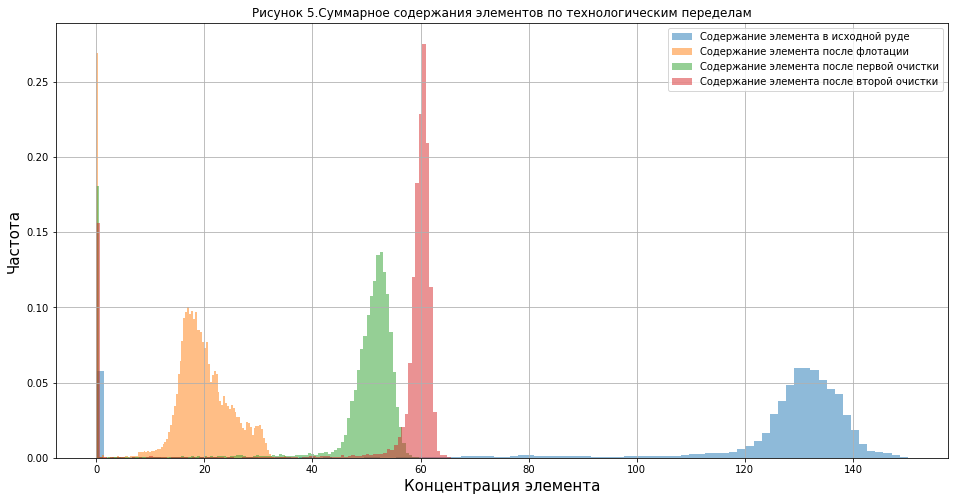

In [21]:
name='Рисунок 5.Суммарное содержания элементов по технологическим переделам'
concentrate_plot (df_train_sum['sum_elements'],df_train_sum['rougher.input.feed_sum'], 
                  df_train_sum['primary_cleaner.output.concentrate_sum'],
                     df_train_sum['final.output.concentrate_sum'])

### ВЫВОД 2###
- Из рисунков 1-3 видно, что концентрация элементов в ходе очистки изменяется неравномерно. Так рисунок 1 показывает, что концентрация золота возрастает с примерно 8 в исходной руде до примерно 45 в конечном концентрате. При этом свинец больше концентрируется в конечном концентрате, а серебро распределено по переделам неравномерно. 
- Рисунок 4 и проверка гипотез показывают, что распределение сырья по крупности в тренировочной и тестовой выборках различаются. Следовательно разделение на выборки проведено не совсем верно. Не очень понятно, что с этим делать дальше и можно ли обучать модели на такой выборке. 
- Рисунки 1-3 показывают, что в выборке содержится значительное количество строк с нулевым содержанием элементов. Таблица 1 и рисунок 2 свидетельствуют, что аномальное поведение концентрации элементов связано в основном с содержанием серебра. Рисунок 5 показывает, что даже в конечном концентрате содержится довольно большое количество наблюдений с нулевым суммарным содержанием элементов. Для обучения моделей необходимо удалить записии с нулевыми значениями в сумме элементов. 

# <a id='part5'>5. ПОДГОТОВКА К ОБУЧЕНИЮ МОДЕЛЕЙ </a>
<a href='#table of contents'>к оглавлению</a>

***Удалим нулевые значения в наблюдениях с суммарной нулевой концентрацией по всем элементам*** 

In [22]:
#получим индексы наблюдений с суммарной нулевой концентрацией на каждом этапе

df_zero_sum_index_rougher=df_train_sum[df_train_sum['rougher.input.feed_sum']==0].index 
df_zero_sum_index_primary_cleaner=df_train_sum[df_train_sum['primary_cleaner.output.concentrate_sum']==0].index 
df_zero_sum_index_final=df_train_sum[df_train_sum['final.output.concentrate_sum']==0].index 
df_zero_sum_index=df_train_sum[df_train_sum['sum_elements']==0].index 

df_index_sum=[df_zero_sum_index_rougher, df_zero_sum_index_primary_cleaner, df_zero_sum_index_final, df_zero_sum_index]

# Объединим списки

def listmerge(lstlst):
    all=[]
    for lst in lstlst:
      all.extend(lst)
    return all

df_sum_index_sum=listmerge(df_index_sum)

#удалим повторяющиеся значения и отсортируем общий список по возрастанию

result_zero_index = sorted(list(set(df_sum_index_sum)))

#выведем промежуточные значения индексов и общий список индексов

print(df_zero_sum_index_rougher)
print(df_zero_sum_index_primary_cleaner)
print(df_zero_sum_index_final)
print(df_zero_sum_index)
print(result_zero_index)

Int64Index([   99,   100,   101,   102,   103,   104,   105,   106,   107,
              108,
            ...
            12047, 12048, 12049, 12050, 12051, 12052, 12053, 12054, 12055,
            12056],
           dtype='int64', length=1213)
Int64Index([   19,    22,    30,    73,    76,    91,    92,    99,   100,
              101,
            ...
            12054, 12055, 12056, 12057, 12067, 12070, 12085, 12086, 12146,
            12280],
           dtype='int64', length=1284)
Int64Index([   99,   100,   101,   102,   103,   104,   105,   106,   107,
              108,
            ...
            12051, 12052, 12053, 12054, 12055, 12056, 12057, 12058, 12059,
            12060],
           dtype='int64', length=1320)
Int64Index([   99,   100,   101,   102,   103,   104,   105,   106,   107,
              108,
            ...
            12047, 12048, 12049, 12050, 12051, 12052, 12053, 12054, 12055,
            12056],
           dtype='int64', length=1100)
[19, 22, 30, 73, 76, 91,

Удалим нулевые значения из тестовой, тренировочной и общей выборок

In [23]:
df_full_drop=df_full.drop(result_zero_index)

In [24]:
df_test_drop=df_test.drop(result_zero_index[:634])

In [25]:
df_train_drop=df_train.drop(result_zero_index)

Выведем получившиеся датафреймы

In [26]:
display(df_full_drop.head(30))
display(df_test_drop.head(30))
display(df_train_drop.head(30))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,...,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,...,13.99,-505.50,11.95,-501.33,10.04,-500.17,7.98,-500.58,14.00,-599.79
2,2016-01-15 02:00:00,6.06,10.21,5.38,42.66,68.12,10.51,0.95,16.21,2.26,...,14.02,-502.52,11.91,-501.13,10.07,-500.13,8.01,-500.52,14.03,-601.43
3,2016-01-15 03:00:00,6.05,9.98,4.86,42.69,68.35,10.42,0.88,16.53,2.15,...,14.04,-500.86,12.00,-501.19,9.97,-499.20,7.98,-500.26,14.01,-600.00
4,2016-01-15 04:00:00,6.15,10.14,4.94,42.77,66.93,10.36,0.79,16.53,2.06,...,14.03,-499.84,11.95,-501.05,9.93,-501.69,7.89,-500.36,14.00,-601.50
5,2016-01-15 05:00:00,6.48,10.05,5.48,41.63,69.47,10.18,0.66,17.00,1.92,...,13.94,-500.97,11.88,-500.40,10.05,-496.37,7.97,-499.36,14.02,-599.71
6,2016-01-15 06:00:00,6.53,10.06,4.57,42.00,69.30,10.30,0.81,16.72,2.06,...,14.05,-500.97,12.09,-500.50,10.00,-497.08,8.01,-500.00,14.03,-600.91
7,2016-01-15 07:00:00,6.13,9.94,4.39,42.45,70.23,10.44,0.95,16.69,2.14,...,13.97,-501.82,12.10,-500.58,9.87,-499.17,7.99,-499.79,13.98,-600.41
8,2016-01-15 08:00:00,5.83,10.07,4.88,43.40,69.69,10.42,1.07,17.20,2.21,...,13.96,-504.25,12.06,-501.17,10.03,-501.18,7.88,-499.73,13.97,-599.06
9,2016-01-15 09:00:00,5.69,9.98,5.28,43.24,70.28,10.49,1.16,17.48,2.21,...,13.99,-503.20,12.05,-500.93,9.96,-502.99,7.98,-500.15,13.98,-598.07


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.80,14.99,8.08,1.01,1398.98,-500.23,1399.14,-499.92,1400.10,...,12.02,-497.80,8.02,-501.29,7.95,-432.32,4.87,-500.04,26.71,-499.71
1,2016-09-01 01:59:59,215.39,14.99,8.08,0.99,1398.78,-500.06,1398.06,-499.78,1396.15,...,12.06,-498.70,8.13,-499.63,7.96,-525.84,4.88,-500.16,25.02,-499.82
2,2016-09-01 02:59:59,215.26,12.88,7.79,1.00,1398.49,-500.87,1398.86,-499.76,1398.08,...,11.96,-498.77,8.10,-500.83,8.07,-500.80,4.91,-499.83,24.99,-500.62
3,2016-09-01 03:59:59,215.34,12.01,7.64,0.86,1399.62,-498.86,1397.44,-499.21,1400.13,...,12.03,-498.35,8.07,-499.47,7.90,-500.87,4.93,-499.96,24.95,-498.71
4,2016-09-01 04:59:59,199.10,10.68,7.53,0.81,1401.27,-500.81,1398.13,-499.50,1402.17,...,12.03,-500.79,8.05,-500.40,8.11,-509.53,4.96,-500.36,25.00,-500.86
5,2016-09-01 05:59:59,168.49,8.82,7.42,0.79,1402.83,-499.30,1401.51,-499.21,1404.09,...,12.03,-499.81,8.04,-500.37,8.04,-510.04,4.98,-499.99,24.98,-500.48
6,2016-09-01 06:59:59,144.13,7.92,7.42,0.79,1398.25,-499.75,1393.26,-499.20,1396.74,...,12.03,-499.47,8.03,-500.98,7.91,-507.96,5.01,-500.04,25.04,-499.50
7,2016-09-01 07:59:59,133.51,8.06,6.99,0.80,1401.67,-501.78,1400.75,-502.51,1400.47,...,12.04,-501.29,8.02,-499.19,8.12,-511.93,5.04,-500.15,25.03,-503.97
8,2016-09-01 08:59:59,133.74,8.00,6.94,0.79,1402.36,-499.98,1400.99,-496.80,1401.17,...,12.00,-499.48,8.01,-500.90,7.97,-521.20,5.06,-499.79,25.01,-497.61
9,2016-09-01 09:59:59,126.96,8.02,7.03,0.81,1400.82,-499.01,1399.98,-499.57,1401.87,...,12.04,-499.99,7.99,-499.75,7.99,-509.95,5.07,-499.29,24.99,-499.27


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,...,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,...,13.99,-505.50,11.95,-501.33,10.04,-500.17,7.98,-500.58,14.00,-599.79
2,2016-01-15 02:00:00,6.06,10.21,5.38,42.66,68.12,10.51,0.95,16.21,2.26,...,14.02,-502.52,11.91,-501.13,10.07,-500.13,8.01,-500.52,14.03,-601.43
3,2016-01-15 03:00:00,6.05,9.98,4.86,42.69,68.35,10.42,0.88,16.53,2.15,...,14.04,-500.86,12.00,-501.19,9.97,-499.20,7.98,-500.26,14.01,-600.00
4,2016-01-15 04:00:00,6.15,10.14,4.94,42.77,66.93,10.36,0.79,16.53,2.06,...,14.03,-499.84,11.95,-501.05,9.93,-501.69,7.89,-500.36,14.00,-601.50
5,2016-01-15 05:00:00,6.48,10.05,5.48,41.63,69.47,10.18,0.66,17.00,1.92,...,13.94,-500.97,11.88,-500.40,10.05,-496.37,7.97,-499.36,14.02,-599.71
6,2016-01-15 06:00:00,6.53,10.06,4.57,42.00,69.30,10.30,0.81,16.72,2.06,...,14.05,-500.97,12.09,-500.50,10.00,-497.08,8.01,-500.00,14.03,-600.91
7,2016-01-15 07:00:00,6.13,9.94,4.39,42.45,70.23,10.44,0.95,16.69,2.14,...,13.97,-501.82,12.10,-500.58,9.87,-499.17,7.99,-499.79,13.98,-600.41
8,2016-01-15 08:00:00,5.83,10.07,4.88,43.40,69.69,10.42,1.07,17.20,2.21,...,13.96,-504.25,12.06,-501.17,10.03,-501.18,7.88,-499.73,13.97,-599.06
9,2016-01-15 09:00:00,5.69,9.98,5.28,43.24,70.28,10.49,1.16,17.48,2.21,...,13.99,-503.20,12.05,-500.93,9.96,-502.99,7.98,-500.15,13.98,-598.07


Добавим в тестовую выборку целевые признаки для обучения моделей

In [27]:
df_test_drop['final.output.recovery']=df_full_drop['final.output.recovery'][df_test_drop.index]
df_test_drop['rougher.output.recovery']=df_full_drop['rougher.output.recovery'][df_test_drop.index]
display(df_test_drop.head())

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
0,2016-09-01 00:59:59,210.80,14.99,8.08,1.01,1398.98,-500.23,1399.14,-499.92,1400.10,...,8.02,-501.29,7.95,-432.32,4.87,-500.04,26.71,-499.71,70.54,87.11
1,2016-09-01 01:59:59,215.39,14.99,8.08,0.99,1398.78,-500.06,1398.06,-499.78,1396.15,...,8.13,-499.63,7.96,-525.84,4.88,-500.16,25.02,-499.82,69.27,86.84
2,2016-09-01 02:59:59,215.26,12.88,7.79,1.00,1398.49,-500.87,1398.86,-499.76,1398.08,...,8.10,-500.83,8.07,-500.80,4.91,-499.83,24.99,-500.62,68.12,86.84
3,2016-09-01 03:59:59,215.34,12.01,7.64,0.86,1399.62,-498.86,1397.44,-499.21,1400.13,...,8.07,-499.47,7.90,-500.87,4.93,-499.96,24.95,-498.71,68.35,87.23
4,2016-09-01 04:59:59,199.10,10.68,7.53,0.81,1401.27,-500.81,1398.13,-499.50,1402.17,...,8.05,-500.40,8.11,-509.53,4.96,-500.36,25.00,-500.86,66.93,86.69


Удалим из тренировочной выборки признаки которые не участвуют в расчете целевых показателей

In [28]:
#получим список признаков тестовой выборки
columns_test=df_test_drop.columns

#получим список признаков тренировочной выборки
columns_train=df_train_drop.columns

#получим список признаков которых нет в тестовой выборке

columns_sum=[]

for i in columns_train:
    if i not in columns_test:
        columns_sum.append(i)

#удалим лишние признаки из тренировочного датасета
df_train_drop=df_train_drop.drop(columns_sum, axis = 1)
df_train_drop=df_train_drop.drop(['date'], axis = 1)

In [29]:
display(df_train_drop.info())
display(df_train_drop.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15343 entries, 0 to 16859
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   final.output.recovery                       15343 non-null  float64
 1   primary_cleaner.input.sulfate               15343 non-null  float64
 2   primary_cleaner.input.depressant            15343 non-null  float64
 3   primary_cleaner.input.feed_size             15343 non-null  float64
 4   primary_cleaner.input.xanthate              15343 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      15343 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    15343 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      15343 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    15343 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      15343 non-null  float64
 10  primary_cl

None

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,70.54,127.09,10.13,7.25,0.99,1549.78,-498.91,1551.43,-516.40,1549.87,...,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,69.27,125.63,10.30,7.25,1.00,1576.17,-500.90,1575.95,-499.87,1575.99,...,13.99,-505.50,11.95,-501.33,10.04,-500.17,7.98,-500.58,14.00,-599.79
2,68.12,123.82,11.32,7.25,0.99,1601.56,-500.00,1600.39,-500.61,1602.00,...,14.02,-502.52,11.91,-501.13,10.07,-500.13,8.01,-500.52,14.03,-601.43
3,68.35,122.27,11.32,7.25,1.00,1599.97,-500.95,1600.66,-499.68,1600.30,...,14.04,-500.86,12.00,-501.19,9.97,-499.20,7.98,-500.26,14.01,-600.00
4,66.93,117.99,11.91,7.25,1.01,1601.34,-498.98,1601.44,-500.32,1599.58,...,14.03,-499.84,11.95,-501.05,9.93,-501.69,7.89,-500.36,14.00,-601.50
5,69.47,115.58,12.47,7.25,0.97,1602.96,-498.09,1602.07,-500.18,1602.15,...,13.94,-500.97,11.88,-500.40,10.05,-496.37,7.97,-499.36,14.02,-599.71
6,69.30,117.32,12.47,7.25,0.90,1597.53,-500.99,1602.82,-500.70,1603.57,...,14.05,-500.97,12.09,-500.50,10.00,-497.08,8.01,-500.00,14.03,-600.91
7,70.23,124.59,12.47,7.25,0.90,1597.95,-501.59,1601.08,-499.49,1602.63,...,13.97,-501.82,12.10,-500.58,9.87,-499.17,7.99,-499.79,13.98,-600.41
8,69.69,131.78,12.47,7.25,0.89,1601.67,-499.55,1598.80,-499.69,1601.69,...,13.96,-504.25,12.06,-501.17,10.03,-501.18,7.88,-499.73,13.97,-599.06
9,70.28,138.12,12.46,7.25,0.90,1603.44,-499.86,1597.46,-500.27,1600.75,...,13.99,-503.20,12.05,-500.93,9.96,-502.99,7.98,-500.15,13.98,-598.07


# <a id='part6'> 6. ОБУЧЕНИЕ МОДЕЛЕЙ </a>
<a href='#table of contents'>к оглавлению</a>

***Получим данные для обучения моделей***

In [30]:
r=42

In [31]:
features=df_train_drop.drop(['rougher.output.recovery','final.output.recovery'], axis=1) # определим признаки
target=df_train_drop[['rougher.output.recovery','final.output.recovery']] # определим целевые признаки
display(features)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.09,10.13,7.25,0.99,1549.78,-498.91,1551.43,-516.40,1549.87,-498.67,...,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,125.63,10.30,7.25,1.00,1576.17,-500.90,1575.95,-499.87,1575.99,-499.32,...,13.99,-505.50,11.95,-501.33,10.04,-500.17,7.98,-500.58,14.00,-599.79
2,123.82,11.32,7.25,0.99,1601.56,-500.00,1600.39,-500.61,1602.00,-500.87,...,14.02,-502.52,11.91,-501.13,10.07,-500.13,8.01,-500.52,14.03,-601.43
3,122.27,11.32,7.25,1.00,1599.97,-500.95,1600.66,-499.68,1600.30,-500.73,...,14.04,-500.86,12.00,-501.19,9.97,-499.20,7.98,-500.26,14.01,-600.00
4,117.99,11.91,7.25,1.01,1601.34,-498.98,1601.44,-500.32,1599.58,-500.89,...,14.03,-499.84,11.95,-501.05,9.93,-501.69,7.89,-500.36,14.00,-601.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,123.38,8.03,6.50,1.30,1648.42,-400.38,1648.74,-400.36,1648.58,-399.36,...,23.03,-501.17,20.01,-499.74,18.01,-499.83,13.00,-500.16,20.01,-501.30
16856,120.88,7.96,6.50,1.30,1649.82,-399.93,1649.36,-399.72,1648.66,-401.20,...,22.96,-501.61,20.04,-500.25,18.00,-500.40,12.95,-499.90,19.97,-501.04
16857,105.67,7.96,6.50,1.32,1649.17,-399.89,1649.20,-399.68,1647.90,-399.99,...,23.02,-501.71,19.95,-499.86,18.02,-500.45,13.02,-499.91,19.99,-501.52
16858,98.88,7.98,6.50,1.24,1646.55,-398.98,1648.21,-400.38,1648.92,-399.52,...,23.02,-501.15,20.05,-500.31,17.98,-499.27,12.99,-499.98,20.01,-500.63


***Стандартизируем признаки***

In [32]:

scaler = StandardScaler()
scaler.fit(features.loc[:,'primary_cleaner.input.sulfate' : 'secondary_cleaner.state.floatbank6_a_level'])
features.loc[:,'primary_cleaner.input.sulfate' : 'secondary_cleaner.state.floatbank6_a_level'] = scaler.transform(features.loc[:,'primary_cleaner.input.sulfate' : 'secondary_cleaner.state.floatbank6_a_level'])
display(features)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,-0.07,0.40,-0.09,0.32,-0.13,-0.12,-0.13,-0.43,-0.13,-0.11,...,-0.96,-0.30,-0.59,-0.59,-1.05,-0.18,-0.80,-0.20,-0.81,-1.85
1,-0.11,0.44,-0.09,0.35,-0.02,-0.16,-0.03,-0.11,-0.03,-0.12,...,-0.96,-0.35,-0.62,-0.54,-1.03,-0.22,-0.82,-0.20,-0.84,-1.73
2,-0.15,0.72,-0.09,0.32,0.08,-0.14,0.07,-0.13,0.08,-0.15,...,-0.96,-0.30,-0.62,-0.54,-1.03,-0.22,-0.82,-0.20,-0.83,-1.76
3,-0.18,0.72,-0.09,0.34,0.08,-0.16,0.07,-0.11,0.07,-0.15,...,-0.95,-0.28,-0.61,-0.54,-1.04,-0.20,-0.82,-0.19,-0.84,-1.73
4,-0.28,0.88,-0.09,0.37,0.08,-0.12,0.08,-0.12,0.07,-0.15,...,-0.96,-0.26,-0.62,-0.54,-1.05,-0.25,-0.84,-0.19,-0.84,-1.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,-0.16,-0.17,-1.32,1.11,0.28,1.83,0.27,1.80,0.27,1.90,...,0.54,-0.28,0.87,-0.52,0.26,-0.21,0.04,-0.19,0.15,0.18
16856,-0.21,-0.19,-1.32,1.10,0.28,1.84,0.28,1.81,0.27,1.86,...,0.53,-0.29,0.87,-0.52,0.26,-0.23,0.03,-0.19,0.14,0.19
16857,-0.56,-0.19,-1.32,1.14,0.28,1.84,0.28,1.81,0.27,1.89,...,0.54,-0.29,0.86,-0.52,0.27,-0.23,0.04,-0.19,0.14,0.18
16858,-0.71,-0.19,-1.32,0.95,0.27,1.86,0.27,1.80,0.27,1.90,...,0.54,-0.28,0.88,-0.53,0.26,-0.20,0.03,-0.19,0.15,0.19


***Напишем функции для вычисления метрик***

sMAPE рассчитывается по формуле

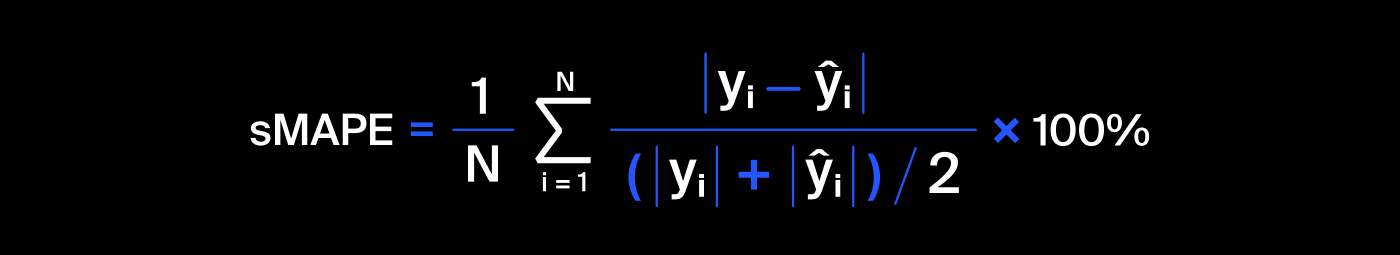

In [33]:
display(Image('https://pictures.s3.yandex.net/resources/smape_1576239058.jpg'))

In [34]:
def sMAPE_func (target, predicted):
    sMAPE=(1/len(target)*np.sum(2*np.abs(target-predicted)/(np.abs(target)+np.abs(predicted))))*100
    return sMAPE

Итоговое sMAPE рассчитывается по формуле

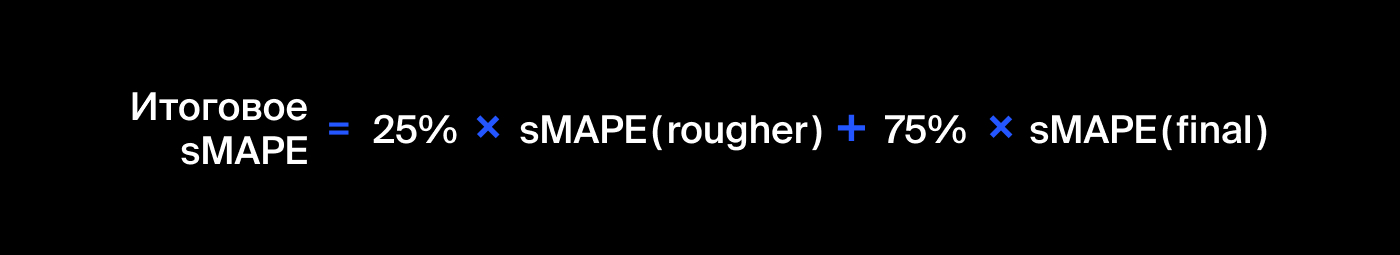

In [35]:
display(Image('https://pictures.s3.yandex.net/resources/_smape_1576239054.jpg'))

In [36]:
def sMAPE_func_total  (sMAPE_rougher, sMAPE_final):
    sMAPE_total=0.25*sMAPE_rougher+0.75*sMAPE_final
    return  sMAPE_total

## <a id='part7'> 6.1. Обучение моделей для предсказания rougher.output.recovery </a>
<a href='#table of contents'>к оглавлению</a>

Для обучения модели необходимо использовать только те признаки которые характеризуют исходное сырье и этап флотации

In [37]:
features_rougher=features[['rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',]]
target_rougher=target['rougher.output.recovery']

display(features_rougher.head())
display(target_rougher.head())

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,-0.98,-0.93,0.52,-0.19,0.23,-0.52,0.16,0.23,0.19,0.25,...,1.33,0.56,1.29,0.46,1.67,0.32,1.55,0.23,1.95,0.28
1,-0.95,-0.95,0.53,-0.13,0.10,-0.53,0.15,0.23,0.23,0.25,...,1.32,0.31,1.28,0.33,1.68,0.34,1.53,0.31,1.86,0.31
2,-0.97,-1.03,0.57,-0.12,0.12,-0.58,0.14,0.36,0.21,0.37,...,1.32,0.31,1.28,0.32,1.68,0.34,1.53,0.32,1.87,0.30
3,-1.00,-1.13,0.67,-0.11,0.24,-0.68,0.06,0.36,0.16,0.37,...,1.32,0.30,1.28,0.33,1.67,0.34,1.54,0.32,1.87,0.31
4,-0.99,-1.33,0.65,-0.17,-0.08,-0.87,-0.12,0.36,-0.02,0.36,...,1.32,0.32,1.28,0.32,1.68,0.34,1.54,0.34,1.87,0.30


0   87.11
1   86.84
2   86.84
3   87.23
4   86.69
Name: rougher.output.recovery, dtype: float64

Создадим функции для обучения моделей

In [38]:
#функция для обучения через кросс-валидацию

my_scorer = make_scorer(sMAPE_func, greater_is_better=True)

def learning_model (features, target, model):
    final_score=cross_val_score(model, features, target, scoring=my_scorer, cv=5)
    print("Среднее sMAPE:", final_score.mean())
    return final_score.mean()

#функция для обучения через GridSearchCV

def learning_model_Grid (model, features, target):
    grid=GridSearchCV(model, parametrs, scoring=my_scorer, cv=5)
    model_fit=grid.fit(features, target)
    print("Лучшее sMAPE:", grid.best_score_)
    print("Лучшие параметры:", grid.best_params_)
    return model_fit

***Обучим модель линейной регресии***

In [39]:
model = LinearRegression()
sMAPE_LinReg_rougher=learning_model(features_rougher, target_rougher, model)

Среднее sMAPE: 13.92955423394074


***Обучим модель дерева решений***

In [40]:
#создадим словарь с перебираемыми параметрами
parametrs = { 'max_depth': range (1,20, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2)}

In [41]:
%%time

model = DecisionTreeRegressor(random_state=r) 
learning_model_Grid(model, features_rougher, target_rougher)

Лучшее sMAPE: 21.014357663966745
Лучшие параметры: {'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 4}
Wall time: 6min 14s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': range(1, 20, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2)},
             scoring=make_scorer(sMAPE_func))

***Обучим модель случайного леса***

In [42]:
#создадим словарь с перебираемыми параметрами
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2)}

In [ ]:
%%time

model=RandomForestRegressor()
learning_model_Grid(model, features_rougher, target_rougher)

Лучшие параметры: {'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 10}  
Подбор параметров занял - ***Wall time: 3h 13min 8s***

***Забыл указать вывод лучшего значения метрики вначале, но 3 часа ждать не хочется, поэтому обучим модель   
с лучшими параметрами еще раз***

In [43]:
model_rougher = RandomForestRegressor(random_state=r, max_depth=11, min_samples_leaf=2,   
                              min_samples_split=6, n_estimators=10) 

model_rougher.fit(features_rougher, target_rougher) 
predictions = model_rougher.predict(features_rougher)
result = sMAPE_func (target_rougher, predictions)
print(predictions, target_rougher)
print("Лучшее SMAPe:", result)

[78.89864373 78.89864373 78.89864373 ... 89.82507507 89.82507507
 89.82507507] 0       87.11
1       86.84
2       86.84
3       87.23
4       86.69
         ... 
16855   89.57
16856   87.72
16857   88.89
16858   89.86
16859   89.51
Name: rougher.output.recovery, Length: 15343, dtype: float64
Лучшее SMAPe: 8.41123740511886


***Сравним точность моделей*** 

In [44]:
data = {'Модель,': ['Линейная регрессия', 'Дерево решений', 'Случайный лес'], 
        'sMAPE,%': [13.92, 21, 8.41]}
table= pd.DataFrame.from_dict(data)
print('Таблица 3. Сравнение качества предсказания моделей на тренировочной выборке')
display(table)

Таблица 3. Сравнение качества предсказания моделей на тренировочной выборке


,"Модель,","sMAPE,%"
0,Линейная регрессия,13.92
1,Дерево решений,21.00
2,Случайный лес,8.41


***Как видно из таблциы 3 минимальная функция ошибки равная 8% получена для модели случайный лес. 
Проверим предсказания модели на тестовых данных***

Получим тестовую выборку

In [67]:
features_rougher_test=df_test_drop[['rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',]]

target_rougher_test=df_test_drop['rougher.output.recovery']
display(features_rougher_test.head())
display(target_rougher_test.head())

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,13.13,5.64,489.79,62.71,42.02,12.08,16.92,6.15,16.87,6.15,...,1249.74,-399.11,1249.75,-399.40,1198.29,-399.49,999.47,-399.53,949.57,-398.18
1,13.04,5.53,490.10,61.96,41.19,11.92,17.00,6.00,17.00,6.00,...,1248.40,-399.95,1249.51,-399.63,1200.51,-399.94,1000.00,-399.49,950.20,-405.79
2,13.14,5.43,489.62,66.90,42.55,12.09,16.99,5.85,16.98,5.85,...,1247.44,-400.26,1248.21,-401.07,1199.77,-400.79,999.93,-399.24,950.32,-400.86
3,12.40,5.11,476.62,59.87,41.06,12.18,16.53,5.80,16.52,5.80,...,1251.32,-398.66,1250.49,-399.75,1199.40,-397.50,1001.93,-400.44,950.74,-399.80
4,11.33,4.77,488.25,63.32,41.27,11.29,13.61,5.74,13.65,5.74,...,1304.66,-399.51,1306.46,-399.05,1248.70,-400.88,1058.84,-398.99,949.65,-399.28


0   87.11
1   86.84
2   86.84
3   87.23
4   86.69
Name: rougher.output.recovery, dtype: float64

In [68]:
model_rougher = RandomForestRegressor(random_state=r, max_depth=11, min_samples_leaf=2,   
                              min_samples_split=6, n_estimators=10) 

model_rougher.fit(features_rougher_test, target_rougher_test) 
predictions = model_rougher.predict(features_rougher_test)
result = sMAPE_func (target_rougher_test, predictions)

print("Лучшее SMAPe:", result)

Лучшее SMAPe: 8.24950087847036


### Промежуточный вывод ###
sMAPE на тестовых данных получился даже меньше чем на тренировочных. Следовательно лучшей моделью является случайный лес

***Сравним лучшую модель с константной моделью*** 

In [69]:
result = sMAPE_func (target_rougher_test, target_rougher_test.mean())
print("Лучшее SMAPe:", result)   

Лучшее SMAPe: 12.400072105809494


### Промежуточный вывод: ###
Обученная модель адекватна

## <a id='part8'> 6.2. Обучение моделей для предсказания final.output.recovery </a>
<a href='#table of contents'>к оглавлению</a>

Получим признаки для обучения моделей

In [60]:
features_final=features
target_final=target['final.output.recovery']

display(features_final.head())
display(target_final.head())

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,-0.07,0.40,-0.09,0.32,-0.13,-0.12,-0.13,-0.43,-0.13,-0.11,...,-0.96,-0.30,-0.59,-0.59,-1.05,-0.18,-0.80,-0.20,-0.81,-1.85
1,-0.11,0.44,-0.09,0.35,-0.02,-0.16,-0.03,-0.11,-0.03,-0.12,...,-0.96,-0.35,-0.62,-0.54,-1.03,-0.22,-0.82,-0.20,-0.84,-1.73
2,-0.15,0.72,-0.09,0.32,0.08,-0.14,0.07,-0.13,0.08,-0.15,...,-0.96,-0.30,-0.62,-0.54,-1.03,-0.22,-0.82,-0.20,-0.83,-1.76
3,-0.18,0.72,-0.09,0.34,0.08,-0.16,0.07,-0.11,0.07,-0.15,...,-0.95,-0.28,-0.61,-0.54,-1.04,-0.20,-0.82,-0.19,-0.84,-1.73
4,-0.28,0.88,-0.09,0.37,0.08,-0.12,0.08,-0.12,0.07,-0.15,...,-0.96,-0.26,-0.62,-0.54,-1.05,-0.25,-0.84,-0.19,-0.84,-1.76


0   70.54
1   69.27
2   68.12
3   68.35
4   66.93
Name: final.output.recovery, dtype: float64

***Обучим модель линейной регресии***

In [61]:
model = LinearRegression()
sMAPE_LinReg_rougher=learning_model(features_final, target_final, model)

Среднее sMAPE: 13.520026882744421


***Обучим модель дерева решений***

In [64]:
#создадим словарь с перебираемыми параметрами
parametrs = { 'max_depth': range (1,10, 2),
              'min_samples_leaf': range (1,6),
              'min_samples_split': range (2,6,2)}

In [65]:
%%time

model = DecisionTreeRegressor(random_state=r) 
learning_model_Grid(model, features_final, target_final)

Лучшее sMAPE: 14.007386861539453
Лучшие параметры: {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4}
Wall time: 2min 8s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': range(1, 10, 2),
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(2, 6, 2)},
             scoring=make_scorer(sMAPE_func))

***Обучим модель случайного леса***

Обучим модель с лучшими параметрами

In [70]:
model_rougher = RandomForestRegressor(random_state=r, max_depth=11, min_samples_leaf=2,   
                              min_samples_split=6, n_estimators=10) 

model_rougher.fit(features_final, target_final) 
predictions = model_rougher.predict(features_final)
result = sMAPE_func (target_final, predictions)
print("Лучшее SMAPe:", result)

Лучшее SMAPe: 6.068174520328572


***Сравним точность моделей*** 

In [71]:
data = {'Модель,': ['Линейная регрессия', 'Дерево решений', 'Случайный лес'], 
        'sMAPE,%': [13.52, 14.00, 6.07]}
table= pd.DataFrame.from_dict(data)
print('Таблица 4. Сравнение качества предсказания моделей на тренировочной выборке')
display(table)

Таблица 4. Сравнение качества предсказания моделей на тренировочной выборке


,"Модель,","sMAPE,%"
0,Линейная регрессия,13.52
1,Дерево решений,14.00
2,Случайный лес,6.07


***Промежуточный вывод***  
Модель случайного леса также показала лучшие результаты 

***Проверим предсказания модели на тестовых данных***

Получим признаки и целевой признак

In [77]:
features_final_test=df_test_drop.drop(['date', 'final.output.recovery'], axis=1)

target_final_test=df_test_drop['final.output.recovery']

display(features_final_test.head())
display(target_final_test.head())

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery
0,210.80,14.99,8.08,1.01,1398.98,-500.23,1399.14,-499.92,1400.10,-500.70,...,-497.80,8.02,-501.29,7.95,-432.32,4.87,-500.04,26.71,-499.71,87.11
1,215.39,14.99,8.08,0.99,1398.78,-500.06,1398.06,-499.78,1396.15,-499.24,...,-498.70,8.13,-499.63,7.96,-525.84,4.88,-500.16,25.02,-499.82,86.84
2,215.26,12.88,7.79,1.00,1398.49,-500.87,1398.86,-499.76,1398.08,-502.15,...,-498.77,8.10,-500.83,8.07,-500.80,4.91,-499.83,24.99,-500.62,86.84
3,215.34,12.01,7.64,0.86,1399.62,-498.86,1397.44,-499.21,1400.13,-498.36,...,-498.35,8.07,-499.47,7.90,-500.87,4.93,-499.96,24.95,-498.71,87.23
4,199.10,10.68,7.53,0.81,1401.27,-500.81,1398.13,-499.50,1402.17,-500.81,...,-500.79,8.05,-500.40,8.11,-509.53,4.96,-500.36,25.00,-500.86,86.69


0   70.54
1   69.27
2   68.12
3   68.35
4   66.93
Name: final.output.recovery, dtype: float64

In [78]:
model_rougher = RandomForestRegressor(random_state=r, max_depth=11, min_samples_leaf=2,   
                              min_samples_split=6, n_estimators=10) 

model_rougher.fit(features_final_test, target_final_test) 
predictions = model_rougher.predict(features_final_test)
result = sMAPE_func (target_final_test, predictions)

print("Лучшее SMAPe:", result)

Лучшее SMAPe: 4.631985494401239


***Сравним лучшую модель с константной моделью*** 

In [80]:
result = sMAPE_func (target_final_test, target_final_test.mean())
print("Лучшее SMAPe:", result)   

Лучшее SMAPe: 11.103547565372763


***Промежуточный вывод***  
Модель адекватна


## <a id='part9'> 7. Расчет итогового sMAPE </a>
<a href='#table of contents'>к оглавлению</a>

In [81]:
sMAPE_rourgher=8.25
sMAPE_final=4.63
sMAPE_func_total (sMAPE_rourgher, sMAPE_final)

5.535

# Основной вывод # 

- Лучшей моделью для предсказания целевых значений оказалась модель случайного леса. 
- Итовое значение sMAPE составило 5.35
- Адекватность моделей проверена их сравнением с константной моделью